In [ ]:
# Variáveis de entrada:

# X1: Área da parede externa
# X2: Área do teto
# X3: Área do piso
# X4: Altura
# X5: Orientação
# X6: Tipo de vidro
# X7: Distribuição do vidro
# X8: Transmitância do vidro

# Variáveis de saída:

# Y1: Carga térmica  de aquecimento
# Y2: Carga térmica de resfriamento

# Instalação de Pacotes

In [ ]:
!pip install prince scipy imbalanced-learn seaborn scikit-learn statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import prince
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.interpolate import splrep, BSpline
from sklearn.covariance import EllipticEnvelope
from sklearn.feature_selection import chi2, SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.ensemble import IsolationForest
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 kB 5.9 MB/s eta 0:00:00


# Carregamento e Pré-processamento

In [ ]:
# Carregar dados
df = pd.read_excel('ENB2012_data.xlsx', sheet_name='Φύλλο1', engine='openpyxl')

# Mapeamento de variáveis
input_features = {
    'X1': 'Área Parede Externa',
    'X2': 'Área Teto',
    'X3': 'Área Piso',
    'X4': 'Altura',
    'X5': 'Orientação',
    'X6': 'Tipo de Vidro',
    'X7': 'Distribuição Vidro',
    'X8': 'Transmitância Vidro'
}

output_targets = {
    'Y1': 'Carga Térmica Aquecimento',
    'Y2': 'Carga Térmica Resfriamento'
}

df = df.rename(columns={**input_features, **output_targets})

In [ ]:
df

,Área Parede Externa,Área Teto,Área Piso,Altura,Orientação,Tipo de Vidro,Distribuição Vidro,Transmitância Vidro,Carga Térmica Aquecimento,Carga Térmica Resfriamento
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


# Análise Exploratória


[3.1] Estatísticas Descritivas:
                            count    mean    std     min     25%     50%  \
Área Parede Externa         768.0    0.76   0.11    0.62    0.68    0.75   
Área Teto                   768.0  671.71  88.09  514.50  606.38  673.75   
Área Piso                   768.0  318.50  43.63  245.00  294.00  318.50   
Altura                      768.0  176.60  45.17  110.25  140.88  183.75   
Orientação                  768.0    5.25   1.75    3.50    3.50    5.25   
Tipo de Vidro               768.0    3.50   1.12    2.00    2.75    3.50   
Distribuição Vidro          768.0    0.23   0.13    0.00    0.10    0.25   
Transmitância Vidro         768.0    2.81   1.55    0.00    1.75    3.00   
Carga Térmica Aquecimento   768.0   22.31  10.09    6.01   12.99   18.95   
Carga Térmica Resfriamento  768.0   24.59   9.51   10.90   15.62   22.08   

                               75%     max  
Área Parede Externa           0.83    0.98  
Área Teto                   741.12  808.

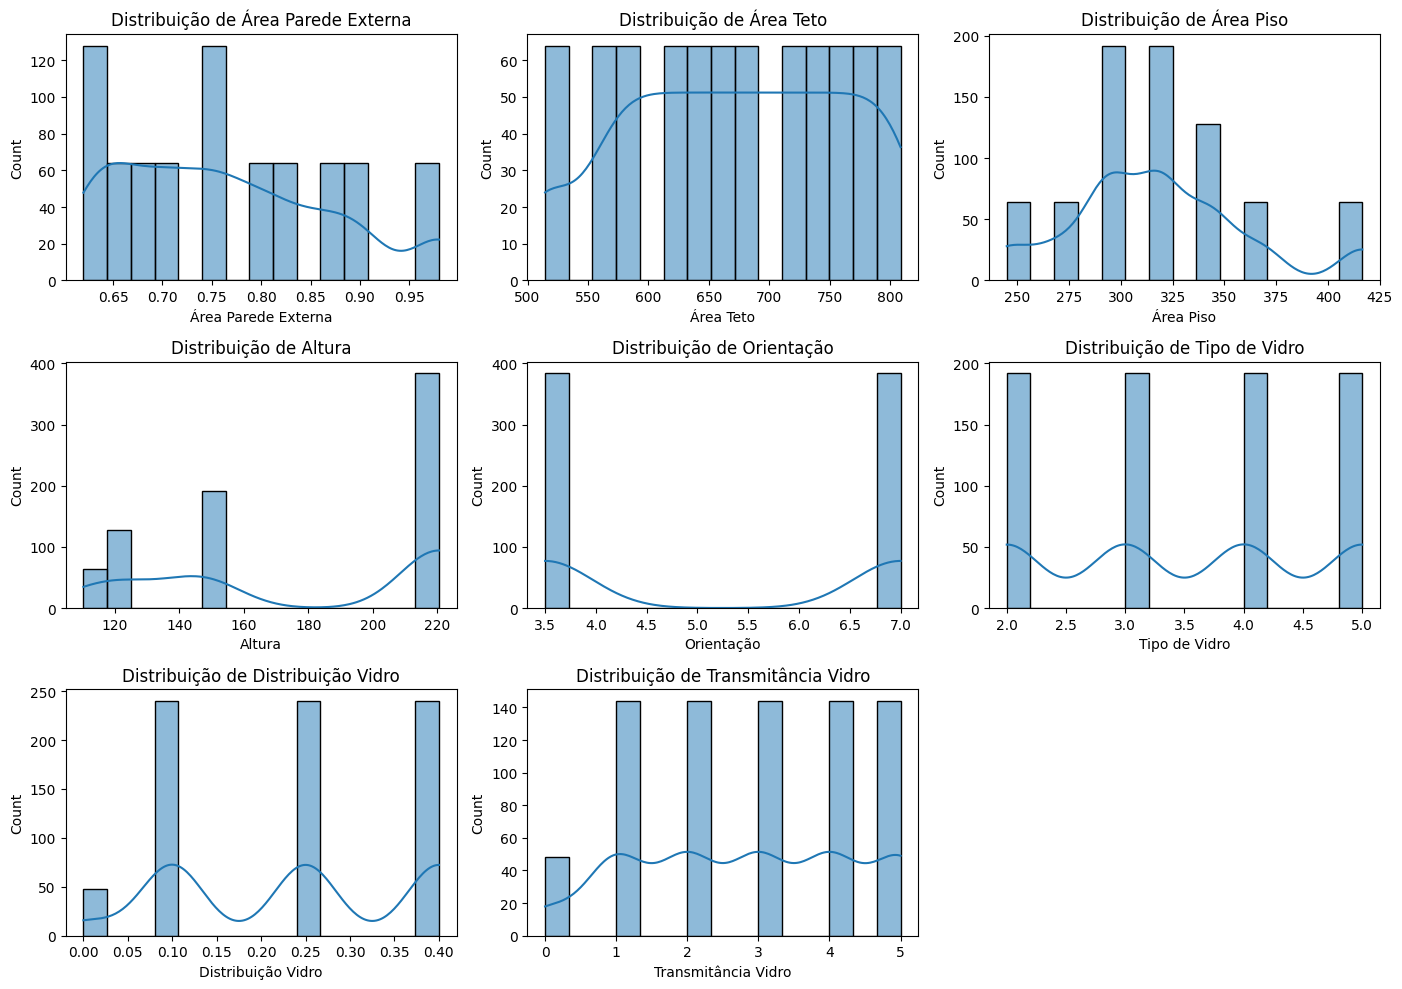

In [ ]:
# Estatísticas Descritivas
print("\n[3.1] Estatísticas Descritivas:")
print(df.describe().transpose().round(2))

# Histogramas
plt.figure(figsize=(14,10))
for i, col in enumerate(input_features.values(), 1):
    plt.subplot(3,3,i)
    sns.histplot(df[col], kde=True, bins=15)
    plt.title(f'Distribuição de {col}')
plt.tight_layout()
plt.show()

# Análise de Correlação

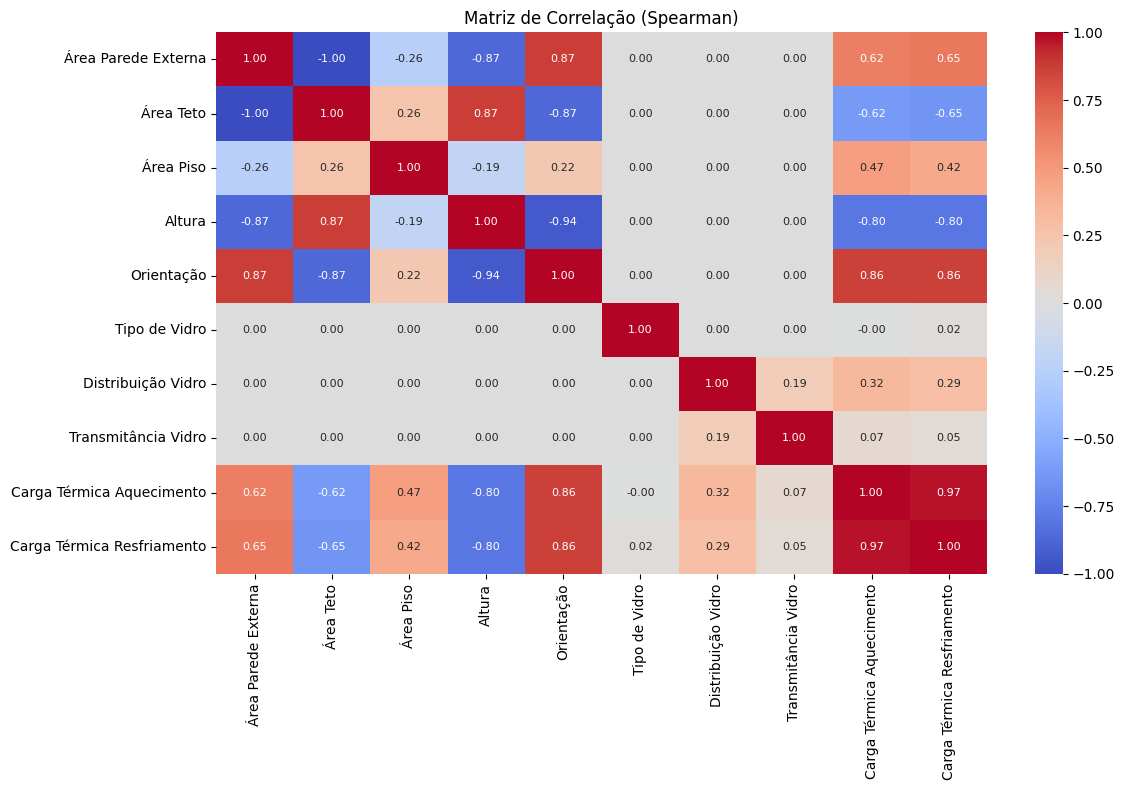

In [ ]:
# Matrizes de Correlação
methods = ['spearman']
for method in methods:
    plt.figure(figsize=(12,8))
    sns.heatmap(df.corr(method=method),
                annot=True,
                cmap='coolwarm',
                center=0,
                fmt=".2f",
                annot_kws={"size":8})
    plt.title(f'Matriz de Correlação ({method.capitalize()})')
    plt.tight_layout()
    plt.show()

Interpretação:

Fortes Correlações Positivas
- **Carga Térmica de Aquecimento e Resfriamento**

Ambientes que exigem mais energia para aquecer também tendem a exigir mais para resfriar — indicativo de ambientes com baixa eficiência térmica ou exposição solar intensa.

- **Orientação com Carga Térmica (Aquecimento e Resfriamento)**

A orientação do ambiente (provavelmente em relação ao sol) afeta fortemente a carga térmica. Ambientes mais expostos ao sol (ex: norte ou oeste) tendem a demandar mais energia.

- **Área Parede Externa com Carga Térmica**

Ambientes com maior área de parede externa têm mais troca térmica com o exterior → maior demanda térmica.

Fortes Correlações Negativas
- **Altura com Carga Térmica (Aquecimento e Resfriamento)**
Ambientes mais altos tendem a demandar menos energia térmica. Isso pode se dever à maior dispersão de calor em pé-direitos mais altos.

- **Área Teto com Carga Térmica**
Ambientes com teto maior talvez sejam mais abertos ou bem ventilados, reduzindo demanda térmica


# Análise de Outliers

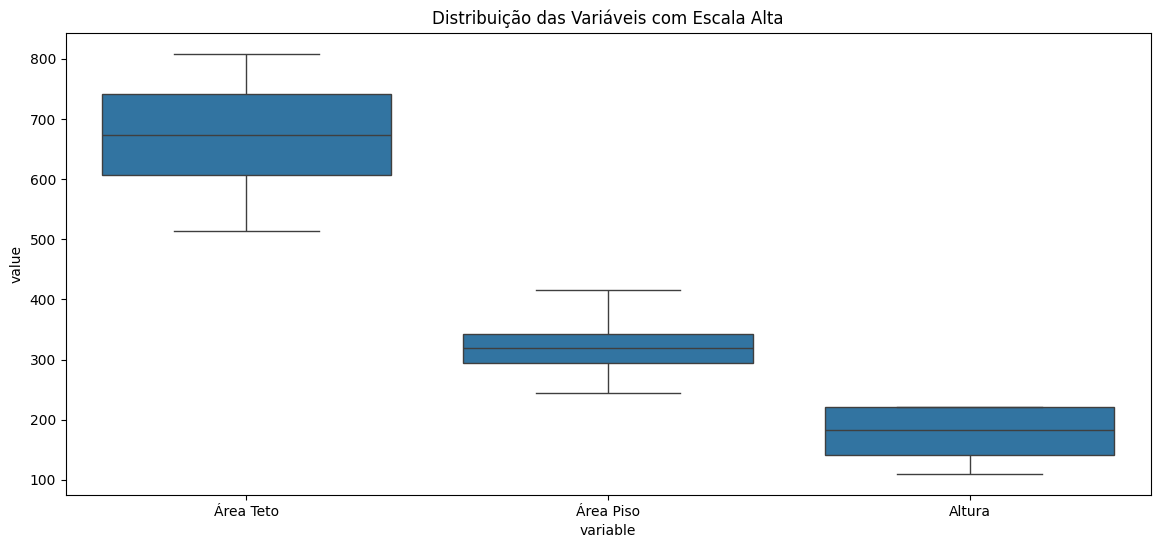

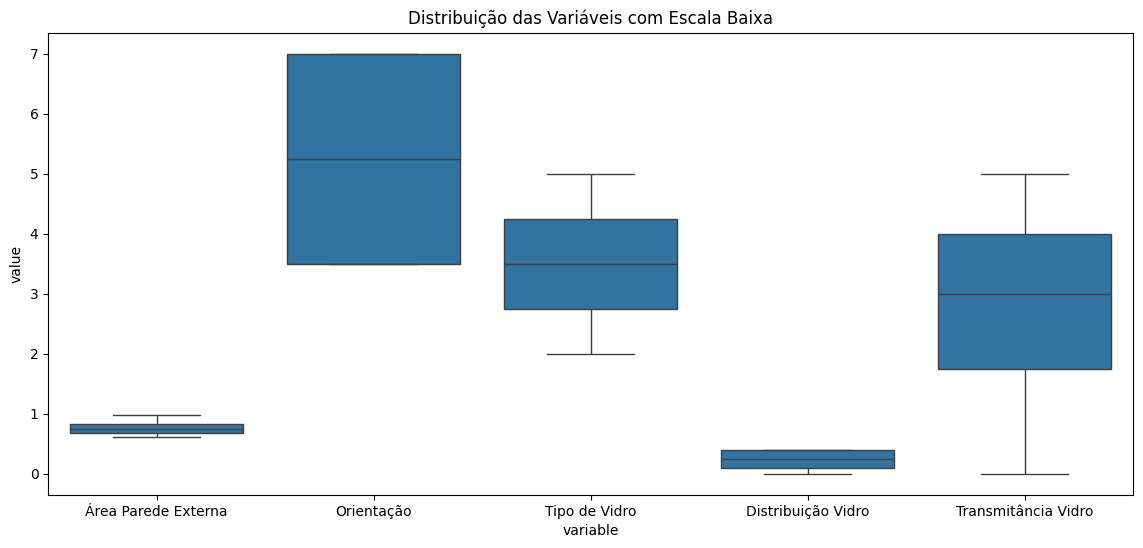

In [ ]:
# Boxplots

# Separar variáveis maiores e menores
high_range = ['Área Teto', 'Área Piso', 'Altura']
low_range = ['Área Parede Externa', 'Orientação', 'Tipo de Vidro', 'Distribuição Vidro', 'Transmitância Vidro']

# Plotar high range
plt.figure(figsize=(14, 6))
df_melt_high = pd.melt(df[high_range])
sns.boxplot(x='variable', y='value', data=df_melt_high)
plt.title('Distribuição das Variáveis com Escala Alta')
plt.show()

# Plotar low range
plt.figure(figsize=(14, 6))
df_melt_low = pd.melt(df[low_range])
sns.boxplot(x='variable', y='value', data=df_melt_low)
plt.title('Distribuição das Variáveis com Escala Baixa')
plt.show()

# Análise de Componentes Principais (PCA)

In [ ]:
# Inicialização do PCA com engine sklearn
pca = prince.PCA(
    n_components=8,
    n_iter=10,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=200
)

# Ajuste do modelo ao dataframe
pca = pca.fit(df)

# Resumo dos autovalores e variância explicada
summary = pca.eigenvalues_summary
print(summary)


          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              5.223        52.23%                     52.23%
1              1.533        15.33%                     67.56%
2              1.219        12.19%                     79.75%
3              1.000        10.00%                     89.75%
4              0.805         8.05%                     97.80%
5              0.163         1.63%                     99.43%
6              0.033         0.33%                     99.76%
7              0.019         0.19%                     99.96%


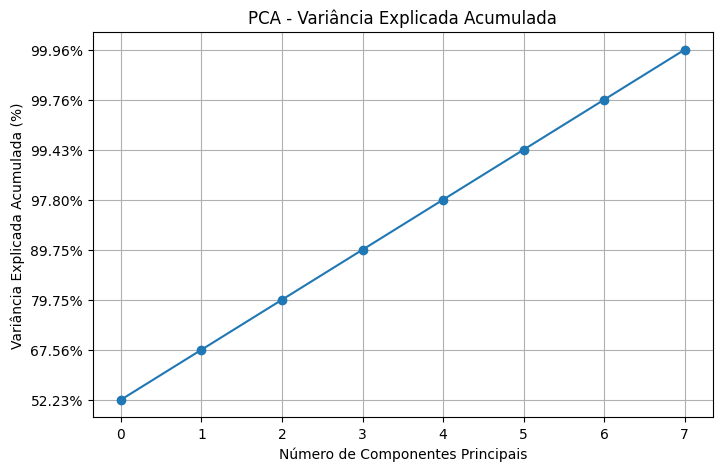

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(summary['% of variance (cumulative)'], marker='o')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada (%)')
plt.title('PCA - Variância Explicada Acumulada')
plt.grid(True)
plt.show()

In [ ]:
pca.scree_plot()

alt.Chart(...)

In [ ]:
pca.column_correlations

component,0,1,2,3,4,5,6,7
variable,,,,,,,,
Área Parede Externa,0.864412,0.468090,-0.106179,-0.000426,0.005076,-0.124730,-0.069281,0.002702
Área Teto,-0.885906,-0.448464,0.100358,0.000446,-0.003463,0.053053,0.005838,0.000302
Área Piso,0.242876,-0.847338,0.411617,0.007436,0.124533,-0.193427,-0.023396,-0.006623
Altura,-0.981180,-0.028086,-0.100931,-0.003157,-0.063521,0.145152,0.016992,0.003493
Orientação,0.980749,0.002379,0.102184,0.002894,0.056331,0.004602,0.154686,-0.016301
Tipo de Vidro,0.002557,-0.006169,0.001302,-0.999964,0.003420,-0.003374,0.000748,0.001529
Distribuição Vidro,0.105819,-0.376667,-0.713841,0.000063,-0.570859,-0.105298,0.016357,-0.010947
Transmitância Vidro,0.035383,-0.233115,-0.704699,0.002906,0.669162,-0.003056,0.000825,-0.002817
Carga Térmica Aquecimento,0.919032,-0.336619,-0.033568,0.006359,-0.069492,0.155402,-0.017876,0.107705


In [ ]:
 pca.column_contributions_.style.format('{:.0%}')

component,0,1,2,3,4,5,6,7
variable,,,,,,,,
Área Parede Externa,14%,14%,1%,0%,0%,10%,15%,0%
Área Teto,15%,13%,1%,0%,0%,2%,0%,0%
Área Piso,1%,47%,14%,0%,2%,23%,2%,0%
Altura,18%,0%,1%,0%,1%,13%,1%,0%
Orientação,18%,0%,1%,0%,0%,0%,72%,1%
Tipo de Vidro,0%,0%,0%,100%,0%,0%,0%,0%
Distribuição Vidro,0%,9%,42%,0%,40%,7%,1%,1%
Transmitância Vidro,0%,4%,41%,0%,56%,0%,0%,0%
Carga Térmica Aquecimento,16%,7%,0%,0%,1%,15%,1%,60%


# Feature selection

- Método Chi2

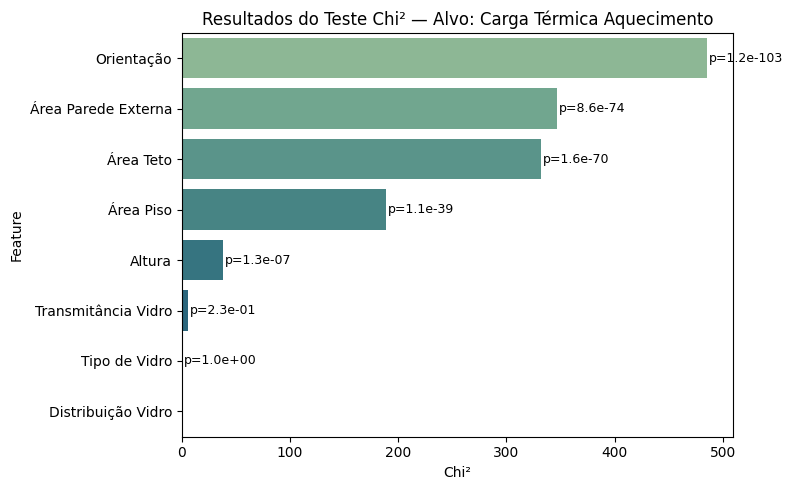

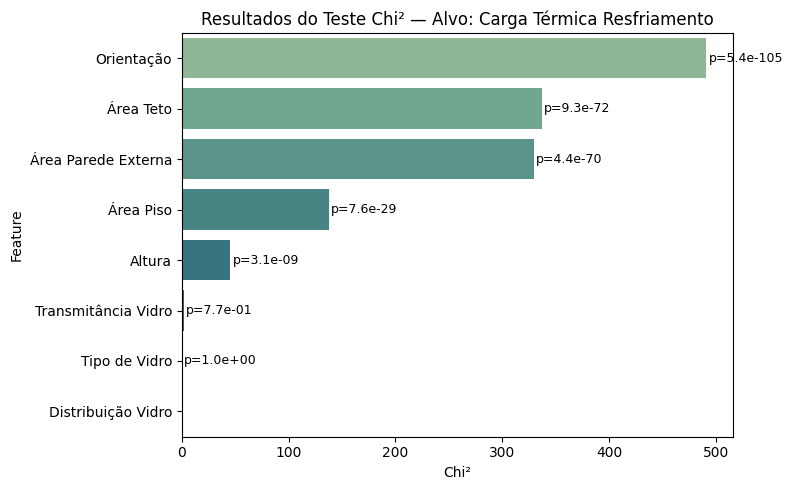

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import chi2

# 1. Discretizar variáveis contínuas
cont_vars = [
    'Área Parede Externa', 'Área Teto', 'Área Piso', 'Altura',
    'Carga Térmica Aquecimento', 'Carga Térmica Resfriamento'
]
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
df_disc = df.copy()
df_disc[cont_vars] = discretizer.fit_transform(df[cont_vars])

# 2. Tratar variáveis categóricas
categorical_vars = ['Orientação', 'Tipo de Vidro', 'Transmitância Vidro','Distribuição Vidro']
df_disc[categorical_vars] = df_disc[categorical_vars].astype(int)

# 3. Função para aplicar Chi²
def run_chi2_analysis(df, features, target_label, bins=5):
    df = df.copy()
    df['Y_binned'] = pd.qcut(df[target_label].rank(method='first'), q=bins, labels=False, duplicates='drop')
    X = df[features]
    y = df['Y_binned']

    chi2_vals, p_vals = chi2(X, y)
    result = pd.DataFrame({
        'Feature': features,
        'Chi2': chi2_vals,
        'p-value': p_vals
    }).sort_values(by='Chi2', ascending=False).reset_index(drop=True)

    return result

# 4. Executar análises para dois alvos
features = cont_vars[:4] + categorical_vars  # exclui os alvos das features
resultado_aquec = run_chi2_analysis(df_disc, features, 'Carga Térmica Aquecimento')
resultado_resfri = run_chi2_analysis(df_disc, features, 'Carga Térmica Resfriamento')

# 5. Função para plotar como na imagem
def plot_chi2_result(df_result, titulo):
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_result, x='Chi2', y='Feature', palette='crest')

    for i, row in df_result.iterrows():
        plt.text(row['Chi2'] + 2, i, f"p={row['p-value']:.1e}", va='center', fontsize=9)

    plt.title(f"Resultados do Teste Chi² — Alvo: {titulo}")
    plt.xlabel("Chi²")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# 6. Plotar ambos
plot_chi2_result(resultado_aquec, "Carga Térmica Aquecimento")
plot_chi2_result(resultado_resfri, "Carga Térmica Resfriamento")


- LASSO

In [ ]:
# Verificar compatibilidade da versão do sklearn
if version.parse(sklearn_version) >= version.parse("1.2"):
    encoder = OneHotEncoder(drop='first', sparse_output=False)
else:
    encoder = OneHotEncoder(drop='first', sparse=False)

# === 1. DEFINIÇÕES INICIAIS ===

# Alvo
target = 'Carga Térmica Aquecimento'
y = df[target]

# Variáveis contínuas
num_features = ['Área Parede Externa', 'Área Teto', 'Área Piso', 'Altura']

# Variáveis categóricas numéricas (apesar de numéricas, são qualitativas)
cat_features = ['Orientação', 'Tipo de Vidro', 'Distribuição Vidro', 'Transmitância Vidro']

# Dados preditores
X = df[num_features + cat_features]

# === 2. PIPELINE: SCALER + ONE-HOT + LASSO ===

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', encoder, cat_features)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectFromModel(LassoCV(cv=5, random_state=42)))
])

# Ajustar pipeline
pipeline.fit(X, y)

# === 3. EXTRAÇÃO DAS FEATURES SELECIONADAS ===

# Obter nomes das features transformadas
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(cat_features)
all_transformed_features = np.concatenate([num_features, ohe_feature_names])

# Máscara de seleção do LASSO
mask = pipeline.named_steps['selector'].get_support()
selected_expanded = all_transformed_features[mask]
removed_expanded = all_transformed_features[~mask]

# === 4. AGRUPAR NOMES ORIGINAIS ===

# Mapeamento de categorias para colunas expandidas
cat_map = defaultdict(list)
for name in ohe_feature_names:
    for col in cat_features:
        if name.startswith(col + "_"):
            cat_map[col].append(name)

# Separar selecionadas/removidas em nomes originais
selected_final = set()
removed_final = set()

# Numéricas
for num in num_features:
    if num in selected_expanded:
        selected_final.add(num)
    else:
        removed_final.add(num)

# Categóricas
for cat in cat_features:
    cols = cat_map.get(cat, [])
    if len(cols) == 0:
        removed_final.add(cat)
    elif any(col in selected_expanded for col in cols):
        selected_final.add(cat)
    else:
        removed_final.add(cat)

# === 5. RESULTADO FINAL ===

print("✅ Variáveis selecionadas com LASSO:")
print(sorted(selected_final))

print("\n❌ Variáveis removidas com LASSO:")
print(sorted(removed_final))


✅ Variáveis selecionadas com LASSO:
['Altura', 'Orientação', 'Tipo de Vidro', 'Transmitância Vidro', 'Área Parede Externa', 'Área Piso', 'Área Teto']

❌ Variáveis removidas com LASSO:
['Distribuição Vidro']
